In [123]:
import numpy as np
from sympy import Eq, symbols, diff, Derivative as D, Function, sqrt as sqrt_, Abs as abs_, solve
from math import sqrt
from matplotlib import pyplot as plt

# AMM Fee Analysis

- https://www.desmos.com/calculator/v7eldnc5ip
- https://www.desmos.com/calculator/lw16uwhowo

## Setup

In [124]:
#A = lambda r: np.array(list(r)) # A(x**2 for x in range(3)) -> np.array([0,1,2])
A = lambda f,r: np.array([f(x) for x in r]) # apply f to r and return np.array

In [125]:
def gamma_gain(p0, p1, N=1):
    """
    how much an arbitrageurs makes on the gamma 
    
    :p0:         price before move
    :p1:         price after move
    :N:          notional
    :returns:    p1-sqrt(p0*p1) if p1 > p0, else sqrt(p0*p1)-p0
    """
    return N*abs(p1-sqrt(p0*p1))
    #return N*(p1-sqrt(p0*p1)) if p1 > p0 else N*(sqrt(p0*p1)-p1)
    
def fee_payment(fee, p1, N=1):
    """
    how much fees to be paid on a transaction
    
    :fee:        percentage fee
    :p1:         price after move
    :N:          notional
    :returns:    fee*N*p1
    """
    return fee*N*p1

## Overview plots

In [126]:
p0 = 1000     # current price
fee = 0.001   # fee (as fraction; eg 0.001 = 0.10%)
rg = 0.01     # viewport range (as fraction)

In [127]:
p_r = np.linspace((1-rg)*p0,(1+rg)*p0, 200)    # price range [p0*(1+-rg)]
gamma_r = A(lambda x: gamma_gain(p0,x), p_r)     # gamma gain as function of price p in p_r
fee_r = A(lambda x:fee_payment(fee,x), p_r)     # fee as function of price p in p_r

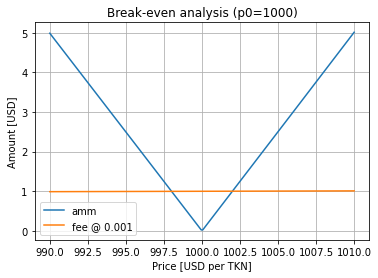

In [128]:
plt.plot(p_r, gamma_r, label="amm")
plt.plot(p_r, fee_r, label=f"fee @ {fee}")
plt.title(f"Break-even analysis (p0={p0})")
plt.xlabel("Price [USD per TKN]")
plt.ylabel("Amount [USD]")
plt.legend()
plt.grid()

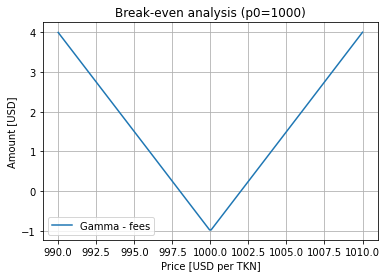

In [129]:
plt.plot(p_r, gamma_r-fee_r, label="Gamma - fees")
plt.title(f"Break-even analysis (p0={p0})")
plt.xlabel("Price [USD per TKN]")
plt.ylabel("Amount [USD]")
plt.legend()
plt.grid()

## Determining break-even levels

We now look how price and fees relate to each other at the break-even points

In [130]:
p0_,p_,fee_ = symbols("p_0 p \phi", real=True, positive=True)

This equation determines the points $p$ where the Gamma return breaks even with fees

In [131]:
breakeven_eq = Eq(abs_(p_-sqrt_(p0_*p_)), p_*fee_)
breakeven_eq

Eq(Abs(sqrt(p)*sqrt(p_0) - p), \phi*p)

We solve it (first with respect to fees then reverse, because sympy)

In [132]:
solve(breakeven_eq)[0][fee_]

Piecewise((-1 + sqrt(p_0)/sqrt(p), sqrt(p)*sqrt(p_0) - p >= 0), (1 - sqrt(p_0)/sqrt(p), True))

In [133]:
breakeven2_eq = Eq(fee_, abs_(1-sqrt_(p0_/p_)))
breakeven2_eq

Eq(\phi, Abs(1 - sqrt(p_0)/sqrt(p)))

This is the operative equation -- break even $p$ as function of $p_0, \phi$

In [134]:
Eq(p_, solve(breakeven2_eq, p_)[0])

Eq(p, p_0/(\phi + 1)**2)

In [135]:
fees_r = np.linspace(0,100,500)
breakeven_r = A(lambda f: p0/(1+f/10000)**2, fees_r)

Here we plot the breakevern price at a specific level of $p_0=1000$. We see for $\phi=0$ the breakeven price is $p=p_0$ and it then goes down slowly.

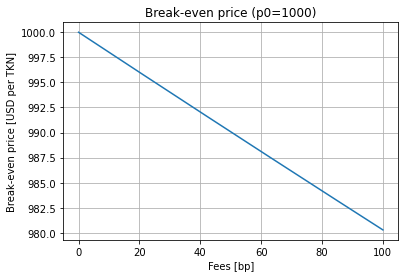

In [136]:
plt.plot(fees_r, breakeven_r, label="break-even price")
plt.title(f"Break-even price (p0={p0})")
plt.xlabel("Fees [bp]")
plt.ylabel("Break-even price [USD per TKN]")
plt.grid()

This is the same analysis but in relative terms. We see that at $\phi=0$ the breakeven level is at 100% (ie infinitesimal moves), and for increasing fees the breakeven level is approximately $p\simeq 1 - 2\phi$. In other words, at a fee level $\phi$, the breakeven percentage move is $2\phi$ in either direction.

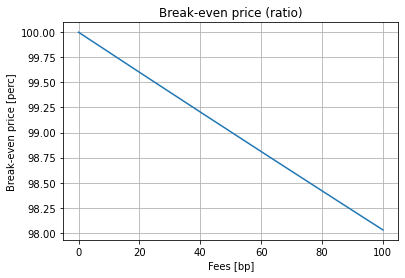

In [137]:
plt.plot(fees_r, breakeven_r/p0*100, label="break-even price")
plt.title(f"Break-even price (ratio)")
plt.xlabel("Fees [bp]")
plt.ylabel("Break-even price [perc]")
plt.grid()

## Convexity gains

In [138]:
help(gamma_gain)

Help on function gamma_gain in module __main__:

gamma_gain(p0, p1, N=1)
    how much an arbitrageurs makes on the gamma 
    
    :p0:         price before move
    :p1:         price after move
    :N:          notional
    :returns:    p1-sqrt(p0*p1) if p1 > p0, else sqrt(p0*p1)-p0



In [139]:
square_f = lambda x: (x-1)**2*0.5
hedged_f = lambda x: ((1+x)/2 - sqrt(x))*5
amm_f = lambda x: gamma_gain(1,x,0.5)
x_r = np.linspace(0.000001,3,100)
t_r = np.linspace(min(x_r)**2,max(x_r)**2,100)
t2_r = np.linspace(min(x_r)**2,1**2,100)

Here we are looking at profiles that are hedged at $x=1$ where $x$ is some normalized spot value. The `hedged` profile is the square root profile which delta-hedged (which happens to be the classic IL profile as well), `amm` is the profile that is created by the AMM arbitrage flow (trade at $\sqrt{x_{old}x}$ when prices are at $x$), and `square` is pure quadratic payoff profile for reference.

The notional amounts have been chosen to roughly balance the charts, but there is no strict size relationship between the three profiles.

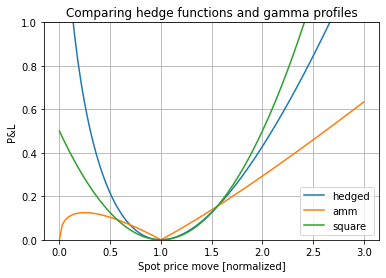

In [140]:
plt.plot(x_r, A(hedged_f, x_r), label="hedged")
plt.plot(x_r, A(amm_f, x_r), label="amm")
plt.plot(x_r, A(square_f, x_r), label="square")
plt.legend()
plt.title(f"Comparing hedge functions and gamma profiles")
plt.xlabel("Spot price move [normalized]")
plt.ylabel("P&L")
plt.ylim(0,1)
plt.grid()

We now perform the break-even analysis: we use a time-like variable $\tau$ that represents rebalancing frequency and we assume that $\Delta x\simeq \sqrt{\tau}$ (volatility has been integrated into the scale of $\tau$. Rather than doing a full Monte Carlo we simply assume a one standard deviation move upwards in a time period tau, hence the $\sqrt{\tau}$ term. We then need to divide by $\tau$ to take into account for the fact that the smaller $\tau$, the more often the rebalancing happens.

We see the `square` profile is flat as it should be: on a perfect square profile, rebalancing frequency does not matter, as the $x^2$ is balanced by the $\sqrt{\tau}$ size of the moves. For the `hedged` profile we see that rebalancing frequency does matter, but not much. The reason for this is higher order terms, as the profile is not fully quadratic. For the `amm` profile finally we find a massive divergence for high-frequency rebalancing (ie $\tau\simeq 0$) because the growth of this profile around the pivot point $x=1$ is not quadratic but linear.

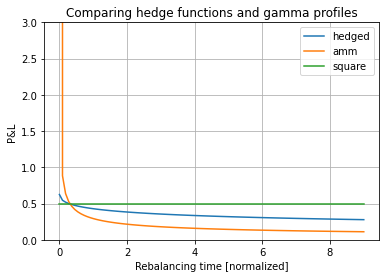

In [141]:
plt.plot(t_r, A(lambda t: hedged_f(1+sqrt(t))/t, t_r), label="hedged")
plt.plot(t_r, A(lambda t: amm_f(1+sqrt(t))/t, t_r), label="amm")
plt.plot(t_r, A(lambda t: square_f(1+sqrt(t))/t, t_r), label="square")
#plt.plot(x_r, A(amm_f, x_r), label="amm")
plt.legend()
plt.title(f"Comparing hedge functions and gamma profiles")
plt.xlabel("Rebalancing time [normalized]")
plt.ylabel("P&L")
plt.ylim(0,3)
plt.grid()

This is the same chart but on a more reasonable scale what rebalancing frequencies is concerned (and even that is still on the high side)

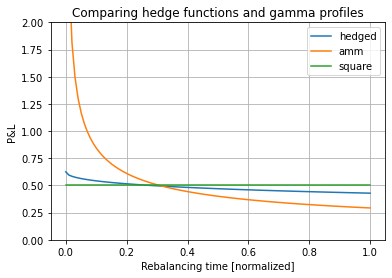

In [142]:
plt.plot(t2_r, A(lambda t: hedged_f(1+sqrt(t))/t, t2_r), label="hedged")
plt.plot(t2_r, A(lambda t: amm_f(1+sqrt(t))/t, t2_r), label="amm")
plt.plot(t2_r, A(lambda t: square_f(1+sqrt(t))/t, t2_r), label="square")
#plt.plot(x_r, A(amm_f, x_r), label="amm")
plt.legend()
plt.title(f"Comparing hedge functions and gamma profiles")
plt.xlabel("Rebalancing time [normalized]")
plt.ylabel("P&L")
plt.ylim(0,2)
plt.grid()